# Ge193 Imaging radar and application
# Homework 3: Range-Doppler / Unfocussed processing


## Problem 1:

Download the data file ersdata.hw3 from the class web page. The format is the same as in the file for homework 2 (line length 10,218 bytes, header 412 bytes), but this time there are 10,100 lines worth of data.

The parameters of the radar are as follows:

- Chirp slope: $4.189166 · 10^{11}$ $Hz/s$
- Pulse length: $37.12$ $\mu s$
- Sample rate fs: $18.96$ $MHz$
- PRF: $1679.9$ $Hz$
- Range $r_0$: $830000$ $m$
- I,Q average values: $15.5$
- Platform velocity: $7550$ $m/s$
- Wavelength: $0.0566$ $m$

In [17]:
## Import modules

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

matplotlib.rcParams.update({'font.size': 18})

In [2]:
def readuint8(file, nsamp, nlines):
    with open(file, 'rb') as fn:
        load_arr = np.frombuffer(fn.read(), dtype=np.uint8)
        load_arr = load_arr.reshape((nlines, nsamp))
    return np.array(load_arr)


def plot_img(data, nhdr=0, title='Data', scale=1, vlim=[None,None], origin='upper', savetif=None):
    if scale > 1:
        clabel = 'Value * {} [-]'.format(scale)
    else:
        clabel = 'Value [-]'
    
    # Adjust the data part for better visualization
    val = np.array(data)
    val[:,nhdr:] = scale * val[:,nhdr:]

    # plot the 2D image
    plt.figure(figsize=[14,14])
    im   = plt.imshow(val, cmap='gray', interpolation='none', vmin=vlim[0], vmax=vlim[1], origin=origin)
    cbar = plt.colorbar(im, shrink=0.3, pad=0.02)
    cbar.set_label(clabel, rotation=270, labelpad=30)
    plt.title(title)
    plt.xlabel('Range [samples]')
    plt.ylabel('Azimuth [lines]')
    if savetif is not None:
        plt.savefig('{}'.format(savetif), format = 'tif')
    plt.show()


def makechirp(N, slope, tau, fs, fc=0, start=0, phi0=0):
    """ Make a reference chirp pulse
    N:     Num of points of the whole pulse   [#]
    slope: slope of the chirp                 [Hz/s]
    tau:   chirp length                       [s]
    fs:    sample rate                        [Hz]
    fc:    central carrier freq               [Hz]
    start: starting sample # of the chirp     [#]
    """
    dt    = 1/fs                                        # sampling time interval          [s]
    npts  = tau * fs                                    # num of points of the pure chirp [#]
    t     = dt * np.arange(-npts/2, npts/2)             # time axis of the pure chirp     [s]
    phase = np.pi*slope*(t**2) + 2*np.pi*fc*t + phi0    # chirp phase                     [rad]
    chirp = np.exp(1j*phase)                           # chirp                           (cmplx)
    chirp = np.pad(chirp, (start,N-len(chirp)-start))   # pad zeros at tail and beginning (cmplx)
    t_arr = dt * np.arange(0, N)                        # time axis of the whole pulse    [s]
    #print('Chirp starts from {} samples, {} mu s'.format(start, 1e6*(start/fs)))
    return chirp, t_arr


def matched_filter(sig, ref):
    sig_fft = np.fft.fft(sig)                           # transform the signal to freq domain
    ref_fft = np.fft.fft(ref)                           # transform the reference chirp to freq domain
    spec    = sig_fft * np.conjugate(ref_fft)           # cross-correlation gives the spectrum
    comp    = np.fft.ifft(spec)                         # inverse transform it back to time domain
    return comp, spec



def plot_freq(freq, val, title, x='Frequency', y='20*log10(|spectrum|), [dB]', xlim=[None,None], ylim=[None,None], unit='MHz', shift=False):
    x += ' [{}]'.format(unit)
    if unit == 'MHz':
        u = 1e-6
    elif unit == 'Hz':
        u = 1
    if shift:
        val = np.fft.fftshift(val)
    plt.figure(figsize=[14,4])
    plt.plot(freq*u, val)
    plt.title(title)
    plt.xlim(min(freq)*u, max(freq)*u)
    plt.xlim(xlim[0], xlim[1])
    plt.ylim(ylim[0], ylim[1])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()    


def plot_time(t, val, title, x=r'Time', y='amplitude [-]', xlim=[None,None], ylim=[None,None], unit='micros', shift=False):
    if unit == 'micros':
        x += r' [$\mu$ s]'
        u = 1e6
    elif unit == 's':
        x += r' [s]'
        u = 1
    if shift:
        val = np.fft.fftshift(val)        
    plt.figure(figsize=[14,4])
    plt.plot(t*u, val)
    plt.title(title)
    plt.xlim(min(t)*u, max(t)*u)
    plt.xlim(xlim[0], xlim[1])
    plt.ylim(ylim[0], ylim[1])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()


def magdB(val):
    mag = 20 * np.log10(np.abs(val) + 1e-30)
    return mag


## Problem 1 (a)

Plot the azimuth spectrum of the data averaged over all valid range bins

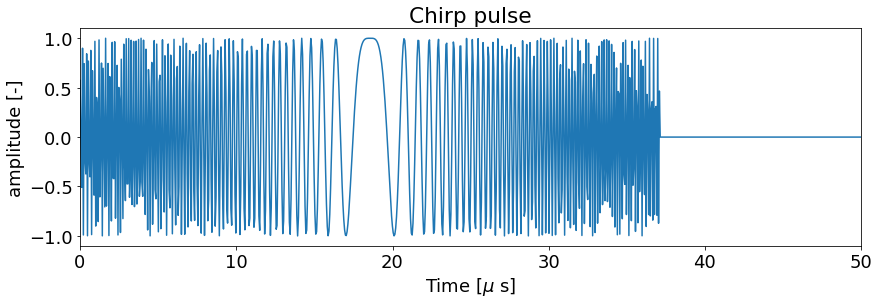

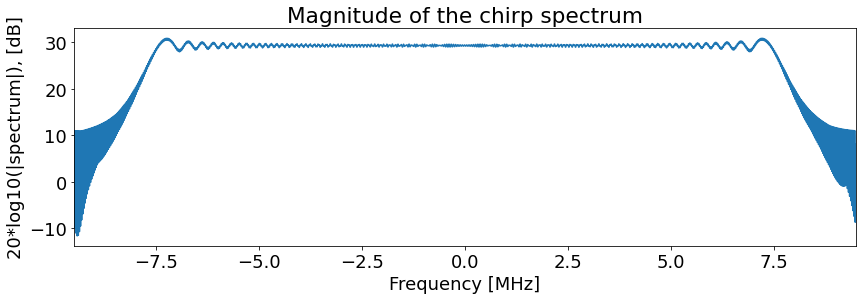

In [3]:
## Problem 1 (a): Plot the azimuth spectrum of the data averaged over all valid range bins

# ERS data info
ERS    = './ersdata.hw3'
nhdr   = 412
nsamp  = 10218
nlines = 10100
PRF    = 1679.9                # pulse repetition freq     [Hz] (the number of pulses of a repeating signal in a second)
r0     = 830000                # platform range            [m]
iq_avg = 15.5                  # I/Q system average values [-]
vx     = 7550                  # platform velocity         [m/s]
wl     = 0.0566                # wavelength                [m]

# ERS chirp parameters
N      = int((nsamp-nhdr)/2)   # number of complex samples [-]
slope  = 4.189166e11           # slope                     [Hz/s]
tau    = 37.12e-6              # pulse length              [s]
bw     = slope * tau           # bandwidth                 [Hz]
fs     = 18.96e6               # sample rate               [Hz]
fc     = 0                     # center Frequency          [Hz]


# create chirp
chirp, t = makechirp(N, slope, tau, fs, fc=fc)  # time axis: total extent N/fs centered at fc*slope

# transform it to a spectrum
chirp_fft = np.fft.fft(chirp)
freqRg    = np.linspace(fc-fs/2, fc+fs/2, N)    # freq axis: total extent fs centered at fc

# calculate the dB spectrum of the signal
chirp_mag = magdB(chirp_fft)

# plot the chirp
plot_time(t, np.real(chirp), 'Chirp pulse', xlim=[0, 50])

# plot the chirp spectrum
plot_freq(freqRg, chirp_mag, 'Magnitude of the chirp spectrum', shift=True)

In [4]:
## Let's read ERS data from the binary file

# read ERS data
data = readuint8(ERS, nsamp, nlines)

# plot ERS data: ERS is digitized in to 5-bit (0~31) in a 8-bit system
plot_img(data, nhdr, title='Raw ERS data', scale=1, vlim=[0,31])

# convert ERS data to complex floats
sig      = data[:, nhdr:] 
sig_odd  = sig[:,  ::2] - iq_avg    # real part
sig_even = sig[:, 1::2] - iq_avg    # imaginary part
sig      = sig_odd + 1j*sig_even    # combine to complex

# transform
sig_fft = np.fft.fft(sig, axis=1)

# averaged over the azimuth direction 
#   (average the abs value of the spectrum, so that complex numbers will not cancel each other)
sig_avgRg_f = np.mean(np.abs(sig_fft), axis=0)

# get the magnitude and plot
sig_avgRg_f_mag = magdB(sig_avgRg_f)

# plot ERS range spectrum
plot_freq(freqRg, sig_avgRg_f_mag, 'Averaged raw ERS spectrum', shift=True)

## Problem 1 (b): 

Determine the Doppler centroid using the spectrum in (a) and also the average phase change method.

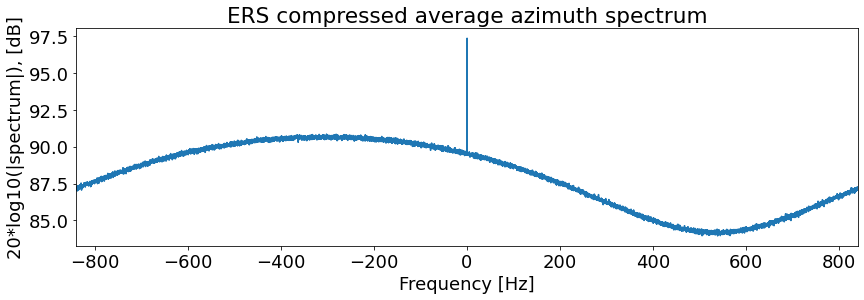

In [5]:
## Compress each range line and create a “range-compressed” image

# do matched filter for each azimuth line
sig_comp_t, sig_comp_f = matched_filter(sig, chirp)

# get only the valid range bins (optional; check handout20, page5)
nvalid = N-int(tau*fs)
sig_comp_t_valid = sig_comp_t[:, :nvalid]

# get the azimuth spectrum of each range bin
#sig_comp_f_valid = sig_comp_f[:, :nvalid]        # this is range spectrum of each azimuth line, not what we want
sig_az_fft = np.fft.fft(sig_comp_t_valid, axis=0)   # this is what we want (contains Doppler information)


# plot the compressed img
plot_img(np.abs(sig_comp_t_valid), title='Magnitude of range compressed image', savetif='./hw3_rangecompressedERS.tiff')

# average the compressed data
sig_comp_avgRg_f = np.mean(np.abs(sig_comp_f), axis=0)  # average range spectrum over azimuth lines (looks like reference chirp)
sig_comp_avgAz_f = np.mean(np.abs(sig_az_fft), axis=1)  # average azimuth spectrum over range bins (Doppler effects)

# get the magnitude and plot
sig_comp_avgRg_f_mag = magdB(sig_comp_avgRg_f)
sig_comp_avgAz_f_mag = magdB(sig_comp_avgAz_f)
freqAz = np.linspace(-PRF/2, PRF/2, nlines)

# plot ERS spectrum
plot_freq(freqRg, sig_comp_avgRg_f_mag, 'ERS compressed average range spectrum', shift=True)
plot_freq(freqAz, sig_comp_avgAz_f_mag, 'ERS compressed average azimuth spectrum', unit='Hz', shift=True)



From eye-balling the spectrum and apply the numerical search, the Doppler centroid appears to be at about -302 Hz, but it is difficult to know what the actual peak is in the noisy spectrum.

We can use the average phase change method. We compute the phase shift $\Delta \phi (j)$ at each range bin $j$ from line $i$ to line $i-1$ in azimuth. We use $P(j)$ to represent the averaged complex change (computed by the sum of multiplications of each azimuth bin with the complex congugate of the next azimuth pixel) of all azimuth pixels at that range bin $j$. $R$ is the full range-compressed image. $j$ is the index of range bins. $i$ is index of azimuth bins.

$$ P(j) = \sum_{i=2}^{N_{az}} R(j, i) R^*(j, i-1) $$

$$ \Delta \phi(j) = tan^{-1}\frac{Im(P(j))}{Re(P(j))} $$

Then average $\Delta \phi (i)$ over all range bins:

$$ \Delta \phi = \frac{\sum_{i=1}^{N_r} \Delta \phi(i)}{N_r} $$

A phase change of $2\pi$ is one cycle. The frequency change of 1 PRF is also one cycle. Therefore, we can relate the phase change to frequency change, which will then tell us about the Doppler centroid $f_D$.:

$$ \frac{\Delta \phi}{2 \pi} = \frac{f_D}{PRF}$$

$$ f_D = PRF \frac{\Delta \phi}{2 \pi} $$

In [6]:
# the average phase change method
def doppler_phase_shift(R, PRF):
    Naz, Nr = R.shape
    psRg = np.zeros(Nr, dtype=np.complex128)
    for i in np.arange(2,Naz):
        psRg += R[i,:] * np.conjugate(R[i-1,:])
    # compute phase shift at each range bin
    phi = np.arctan(np.imag(psRg)/np.real(psRg))
    phi_avg = np.mean(phi)
    fd = PRF * phi_avg/(2*np.pi)
    return fd, phi_avg

def doppler_cent_squint(fd, v, theta, wavelength):
    sine_squint = fd * wavelength * 0.5 * v / np.sin(theta)
    squint = np.arcsin(sine_squint)
    return squint    


# find the spectrum peak, that is the Doppler centroid
idx = np.fft.fftshift(sig_comp_avgAz_f_mag) < 95
fd = freqAz[np.argmax(np.fft.fftshift(sig_comp_avgAz_f_mag)[idx])]
print('Doppler centroid (numerically determined) = {:.3f} MHz'.format(fd))

# find the doppler freq using phase change method
fd, phi_avg = doppler_phase_shift(sig_comp_t_valid, PRF)
print('Doppler centroid (phase shift method) = {:.3f} MHz'.format(fd))



Doppler centroid (numerically determined) = -302.162 MHz
Doppler centroid (phase shift method) = -299.959 MHz


## 2. An unfocussed SAR processor

## Problem 2 (a) 

Calculate the parameters of an unfocused processor for the radar in (1). Evaluate the azimuth resolution, pulse spacing at the spacecraft, and output pixel spacing (a flat-earth approximation is fine). How long would each burst have to be? How often need we repeat if the antenna is 10 m long?


How often need we repeat if the antenna is 10 m long? This is the "repeat cycle time", which is the time separation (in seconds) between illuminating two patches: $$ t_{cyc} = \frac{\lambda r_0}{l} \times \frac{1}{v}$$

where the first term there is the azimuth beamwidth (the ground extent with 10-meter antenna), which is depending on the radar antenna length.

Azimuth resolution of radar [m]: $$\delta_{az} = \sqrt{\lambda r_0}$$

Pulse spacing at the spacecraft [m]: the distance that the platform travels between two consecutive pulses $$ d_{pulse} = \frac{v}{PRF}$$

Minimum number of pulses needed: $$ N^{min}_{p} = \frac{\delta_{az}}{d_{pulse}}$$

We can round the minimum number of pulses to the nearest power of 2, and we get the number of pulses we use, $N_{p}$

Burst length in time [s]: How long would each burst (contains $N_p$ pulses) have to be $$ t_{burst} = \frac{N_{p}}{PRF} $$

Frequency resolution [Hz]: $$\delta_{f} = \frac{PRF}{N_{p}}$$

The output pixel spacing refers to "how much change in x (in meters) per frequency bin". To compute the output pixel spacing, consider the relation between Doppler frequency ($f$) and offset distance ($x$) on the ground:

$$ f_D = \frac{2v}{\lambda}\frac{x}{r_0}$$

$$ \delta_f = \frac{2v}{\lambda}\frac{dx}{r_0}$$

$$ dx = \frac{\delta_f \cdot r_0 \cdot \lambda}{2v} $$



In [7]:
# Repeat cycle time for a 10-m antenna (s)
l = 10               # antenna length [m]
L_az = r0 * wl / l   # ground extent of azimuth beamwidth [m]
t_cyc = L_az / vx    # cycle time between iluminating this patch and the next patch
print('Azimuth beamwidth of a {:.1f}-m antenna = {:.3f} [m]'.format(l, L_az))
print('Repeat cycle time for a {:.1f}-m antenna = {:.3f} [s]'.format(l, t_cyc))

# Azimuth resolution
d_az = np.sqrt(wl * r0)
print('Azimuth Resolution = {:.3f} [m]'.format(d_az))

# Pulse spacing in azimuth
dp = vx / PRF
print('Palse spacing = {:.3f} [m]'.format(dp))

# Minimum num of pulses
num_p = int( 2**np.ceil(np.log2(d_az/dp)) )
print('Num of pulses = {:d} [#]'.format(num_p))

# Frequency resolution
df = PRF / num_p
print('Frequency resolution = {:.3f} [Hz]'.format(df))

# Output pixel spacing
dx = df * r0 * wl / (2*vx)
print('Output pixel spacing = {:.3f} [m]'.format(dx))

# Burst length (s)
t_burst = num_p / PRF
print('Burst length = {:.3f} [s]'.format(t_burst))



Azimuth beamwidth of a 10.0-m antenna = 4697.800 [m]
Repeat cycle time for a 10.0-m antenna = 0.622 [s]
Azimuth Resolution = 216.744 [m]
Palse spacing = 4.494 [m]
Num of pulses = 64 [#]
Frequency resolution = 26.248 [Hz]
Output pixel spacing = 81.662 [m]
Burst length = 0.038 [s]


## Problem 2 (b):

Calculate the single-patch unfocused image from the first few lines of the file. Be sure and correct for the Doppler centroid, and display the result with zero displacement from the boresight at the center of the patch.

To process in azimuth, we need to make sure that we have corrected for the Doppler Centroid accurately. We can do the steering for the entire image and look at the average spectrum again. This time, our highest amplitude should be centered at 0 Hz.

$$R'(i) = R(i) \times exp(-j \times 2\pi \times f_{DC} \times \frac{i}{PRF})$$

where $R(i)$ is the range compressed image at $i^{th}$ azimuth line.

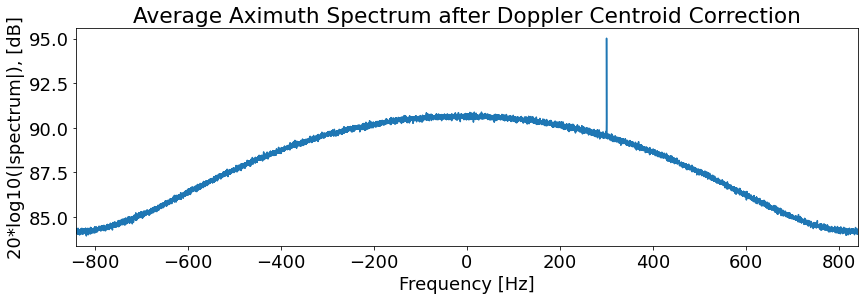

In [8]:
## Doppler Centroid Correction

rcompfd = np.zeros([nlines, nvalid], dtype=np.complex128)

for i in range(nlines):
    rcompfd[i,:] = sig_comp_t_valid[i,:] * np.exp(-1j * 2 * np.pi * fd * i / PRF)


# Check if we have done the doppler shift correctly (the image should now have the peak at zero frequency)
spect_az     = np.fft.fftshift(np.fft.fft(rcompfd, axis=0))
spect_averaz = np.mean(np.abs(spect_az), axis=1)
spectdb_az   = magdB(spect_averaz)

plot_freq(freqAz, spectdb_az, 'Average Aximuth Spectrum after Doppler Centroid Correction', unit='Hz')


Now, we can process the first $N_{p}$ pulses (first patch, and according to above, it is first 64 pulses) and see how the single patch looks. To get square pixels, we can also “multilook” in range by 4 (i.e. average the amplitudes of 4 adjacent range pixels, effectively reducing the number of range bins by 4).

In [9]:
## Estimate the number of range looks needed (optional)

# in order to know the number of looks to take, we need to know the bin spacing in range & azimuth (m/pixel)

# (1) range scatterer size on the ground, dr = c/2/fs/sin(lookangle) [m]
c   = 3e8                            # speed of light
lk  = 25.973                         # look angle
dr  = c/2/fs/np.sin(np.deg2rad(lk))  # Based on the sample rate (handout25, page5)

# (2) azimuth scatterer size, dx [m]

# Num of looks: the ratio between them
nlk = int(np.floor(dx/dr))           # the number of looks we need to take in range to get aquare pixels at the end
print('Number of looks needed: {}'.format(nlk))


Number of looks needed: 4


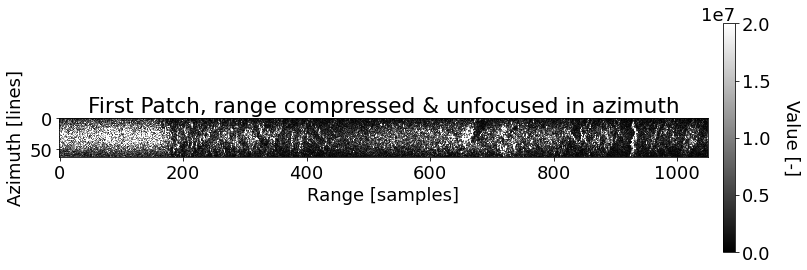

In [10]:
## Process a test image on the first patch (transform the first 64 pulses)
patch     = rcompfd[:num_p, :]
data      = np.abs(np.fft.fftshift(np.fft.fft(patch, axis=0), axes=0))**2


def multi_range(data, nlk):
    bin_azimuth = int(data.shape[0])
    bin_range   = int(data.shape[1]/nlk)
    data_out    = np.zeros([bin_azimuth, bin_range])
    for i in range(bin_range):
        data_out[:,i] = np.mean(data[:, i*nlk:(i+1)*nlk], axis=1)
    return data_out


# multilook in range
image_1patch = multi_range(data, nlk)

# plot the patch
plot_img(image_1patch, title='First Patch, range compressed & unfocused in azimuth', vlim=[0, 2e7])

We can clearly see the antenna pattern in this first patch, where the azimuth edges are darker than the center of the beam.

## Problem 2 (c): 

Determine the patch to patch spacing if we want to process all of the data (in pixels):

$$\Delta_{patch} = \frac{N_p \times d_{pulse}}{dx}$$

In [11]:
# offset between patches
d_patch = (num_p * dp) / dx
print('Patch-to-patch spacing (# pixels offset between patches) = {:.3f} [px]'.format(d_patch))

Patch-to-patch spacing (# pixels offset between patches) = 3.522 [px]


As computed from above, the patch-to-patch spacing (# pixels offset between patches) is 3.522 pixels. This spacing is not a whole number, so we alternate between taking 3 and 4 pixels for the patch-to-patch spacing when computing the final image in part (d).

## Problem 2(d):

Write a multi-looked unfocused processor and create an image from the full ersdata.hw3 data set. Can you begin to identify parts of the image?

First compute the number of patches given the amount of data:

$$N_{patches} = \frac{N_{azlines}}{N_p} = \frac{10100 \ lines}{64 \ pulses}$$

Then compute the number of azimuth pixels in the azimuth multilook image, to preallocate space:

$$N_{az, looks} = N_p + (N_{patches} - 1)\Delta_{patch}$$

In [12]:
## Estimate the num of patches needed

num_patch = int(nlines/num_p)  # number of patches we will process 
Naz       = int(num_p + (num_patch - 1) * d_patch)

print('Number of patches we will process: {}'.format(num_patch))
print('Number of azimuth pixels in the multi-looked image: {}'.format(Naz))

Number of patches we will process: 157
Number of azimuth pixels in the multi-looked image: 613


In [18]:
## Now, do the unfocused processing for the entire image

def azimuth_proc(rcompfd, num_patch, Naz, num_pulse, d_patch):
    bins_range = rcompfd.shape[1]
    unfcs      = np.zeros([Naz, bins_range])     # preallocate the final unfocussed image
    count      = np.zeros([Naz, bins_range])     # preallocate the counting array
    for i in tqdm(np.arange(num_patch)):
        shift = int(np.round(i*d_patch))
        #print('Processing patch {}, lines {}-{}'.format(i+1, shift, shift+num_pulse))
        patch = rcompfd[i*num_pulse:(i+1)*num_pulse, :]
        data  = np.abs(np.fft.fftshift(np.fft.fft(patch, axis=0), axes=0))**2
        unfcs[shift:shift+num_pulse, :] += data
        count[shift:shift+num_pulse, :] += 1
    return unfcs/count


# do the unfocused processing
unfcs = azimuth_proc(rcompfd, num_patch, Naz, num_p, d_patch)


100%|██████████| 157/157 [00:02<00:00, 60.45it/s]


Image size (613, 4200)


Final image size (613, 1050)


Flip the final image size (613, 1050)


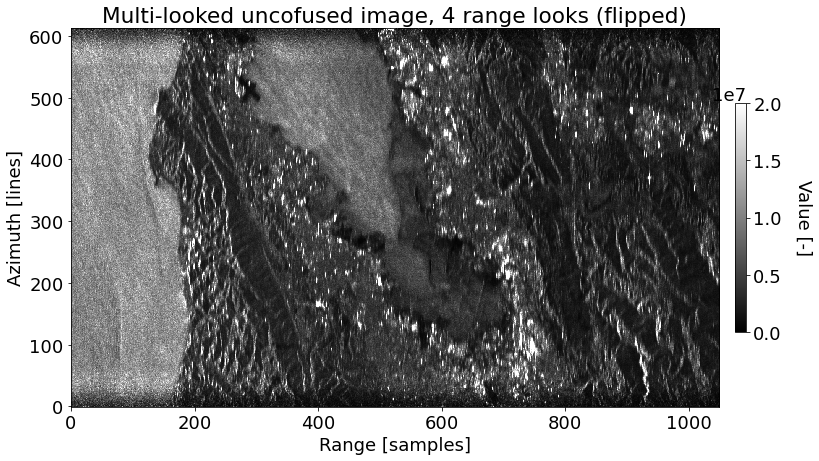

In [27]:
# colorbar limit
vlim = [0,2e7]


## Plot the final image
print('Image size', unfcs.shape)
plot_img(unfcs, title='Multi-looked uncofused image, no range looks', vlim=vlim)


## Multilook in range
imagefinal = multi_range(unfcs, nlk)


## Plot multilooked image
print('Final image size', imagefinal.shape)
plot_img(imagefinal, title='Multi-looked uncofused image, {} range looks'.format(nlk), vlim=vlim)


## Reset the origin of image, so that the first row is at the bottom (south)
print('Flip the final image size', imagefinal.shape)
plot_img(imagefinal, title='Multi-looked uncofused image, {} range looks (flipped)'.format(nlk), vlim=vlim, origin='lower')


If we take 4 looks in range, we get approximately square pixels and the image is much more recognizable. It’s the Bay Area!